<a href="https://colab.research.google.com/github/DakshiW/project_group_i/blob/main/Fiona/unswproject_v8_20230402.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

# Clone data from GitHub

In [1]:
# Clone the ZZSC9020 project repository from GitHub
!git clone https://github.com/UNSW-ZZSC9020-2023H2/project.git

Cloning into 'project'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 1), reused 1 (delta 1), pack-reused 21
Unpacking objects: 100% (25/25), 121.23 MiB | 12.50 MiB/s, done.
Updating files: 100% (12/12), done.


In [2]:
# Create a data folder
!mkdir -p data

In [3]:
# Joint forecastdemand_nsw files into a single file. 
!cat project/data/forecastdemand_nsw.csv.zip.part* > data/forecastdemand_nsw.csv.zip

In [4]:
# Unzip the data files into the data folder
!unzip data/forecastdemand_nsw.csv.zip -d data
!unzip project/data/temperature_nsw.csv.zip -d data
!unzip project/data/totaldemand_nsw.csv.zip -d data

Archive:  data/forecastdemand_nsw.csv.zip
  inflating: data/forecastdemand_nsw.csv  
  inflating: data/__MACOSX/._forecastdemand_nsw.csv  
Archive:  project/data/temperature_nsw.csv.zip
  inflating: data/temperature_nsw.csv  
  inflating: data/__MACOSX/._temperature_nsw.csv  
Archive:  project/data/totaldemand_nsw.csv.zip
  inflating: data/totaldemand_nsw.csv  
  inflating: data/__MACOSX/._totaldemand_nsw.csv  


In [5]:
# Remove forecastdemand_nsw.csv.zip
!rm data/forecastdemand_nsw.csv.zip

# Import libraries

In [7]:
# Others
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# for data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_absolute_error as mae
from datetime import date, timedelta
from calendar import monthrange 

# for time series model
!pip install pmdarima
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for machine learning model



# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for performance metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import math
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00


# Data preprocessing

In [8]:
# Load the data
totaldemand = pd.read_csv('data/totaldemand_nsw.csv',index_col='DATETIME').sort_index()
temperature = pd.read_csv('data/temperature_nsw.csv',index_col='DATETIME').sort_index()
forecastdemand = pd.read_csv('data/forecastdemand_nsw.csv',index_col='DATETIME').sort_index()


In [9]:
# Check for NaN values
print(f'NaN values in totaldemand= {totaldemand.isna().sum().sum()}')
print(f'NaN values in temperature= {temperature.isna().sum().sum()}')
print(f'NaN values in forecastdemand= {forecastdemand.isna().sum().sum()}')

NaN values in totaldemand= 0
NaN values in temperature= 0
NaN values in forecastdemand= 0


In [10]:
# Check for zero or negative values
print(f'Zero or negative values in totaldemand= {((totaldemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in temperature= {((temperature.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')
print(f'Zero or negative values in forecastdemand= {((forecastdemand.select_dtypes(include=np.number)<=0).any(axis=1)).sum()}')

Zero or negative values in totaldemand= 0
Zero or negative values in temperature= 36
Zero or negative values in forecastdemand= 0


In [11]:
# Explore extreme temperature values
temperature.loc[temperature['TEMPERATURE']<=0]

,LOCATION,TEMPERATURE
DATETIME,,
2010-03-23 15:00:00,94766.0,-9999.0
2010-04-27 10:00:00,94766.0,-9999.0
2010-05-01 06:00:00,94766.0,-9999.0
2010-06-29 04:30:00,94766.0,-0.2
2010-06-29 05:30:00,94766.0,-0.1
2010-06-29 06:30:00,94766.0,-0.3
2010-06-30 04:30:00,94766.0,-0.3
2010-06-30 05:00:00,94766.0,-0.5
2010-06-30 05:30:00,94766.0,-0.4


In [12]:
# Remove rows with unreasonable values
temperature = temperature.loc[temperature['TEMPERATURE']!=-9999]

In [13]:
# Convert relevant columns to datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
totaldemand.index = pd.to_datetime(totaldemand.index, format=datetime_format)
temperature.index = pd.to_datetime(temperature.index, format=datetime_format)
forecastdemand.index = pd.to_datetime(forecastdemand.index, format=datetime_format)
forecastdemand['LASTCHANGED'] = pd.to_datetime(forecastdemand['LASTCHANGED'], format=datetime_format)

In [14]:
# Drop unwanted columns
totaldemand.drop(['REGIONID'],axis=1,inplace=True)
temperature.drop(['LOCATION'],axis=1,inplace=True)
forecastdemand.drop(['REGIONID','PREDISPATCHSEQNO','PERIODID'],axis=1,inplace=True)

In [15]:
# Create the dataframe for modelling
df = totaldemand.resample('5T').median().interpolate() # resample demand to 5-min bins and fill NaN by linear interpolation
df = df.join(temperature).sort_index().interpolate() # join temperature data and fill NaN by linear interpolation
print(f'Check NaN in df: {df.isna().sum().sum()}')
print(df)

Check NaN in df: 0
                     TOTALDEMAND  TEMPERATURE
DATETIME                                     
2010-01-01 00:00:00      7997.41    23.100000
2010-01-01 00:05:00      7946.51    23.066667
2010-01-01 00:10:00      7921.55    23.033333
2010-01-01 00:15:00      7837.84    23.000000
2010-01-01 00:20:00      7781.11    22.966667
...                          ...          ...
2022-07-31 23:40:00      8180.34    12.500000
2022-07-31 23:45:00      8237.50    12.400000
2022-07-31 23:50:00      8109.83    12.300000
2022-07-31 23:55:00      8044.52    12.200000
2022-08-01 00:00:00      8027.28    12.100000

[1323361 rows x 2 columns]


In [16]:
# Create a dataframe for comaprison between actual and forecast demands
df_forecast = pd.merge(forecastdemand,totaldemand,left_index=True,right_index=True)
df_forecast['DURATION'] = (df_forecast.index - df_forecast['LASTCHANGED']).astype('timedelta64[h]').astype('int')
df_forecast['ERROR'] = abs(df_forecast['FORECASTDEMAND'] - df_forecast['TOTALDEMAND'])/df_forecast['TOTALDEMAND']*100
df_forecast.drop(['FORECASTDEMAND','TOTALDEMAND','LASTCHANGED'],axis=1,inplace=True)

In [17]:
# Set parameters for different prediction time frames

# Short term prediction: 1 day into the future
window_short = 'D'

# Medium term prediction: 1 week into the future
window_medium = 'W'

# Long term prediction: 1 month into the future
window_long = 'M'

In [18]:
# Resample df based on the windows to fit time series model
# Note: demand is divided by 1000 to convert to GW (gigawatts)

# Short term prediction:
ts_short = df.resample(window_short).agg({'TEMPERATURE':'median','TOTALDEMAND':lambda x:x.sum()/1000})
ts_short = ts_short.iloc[:-1] # remove the last value after resampling to 1D
print(ts_short)

# Medium term prediction:
ts_medium = df.resample(window_medium).agg({'TEMPERATURE':'median','TOTALDEMAND':lambda x:x.sum()/1000})
ts_medium = ts_medium.iloc[1:-1] # remove the first and last value after resampling to 1W
print(ts_medium)

# Long term prediction:
ts_long = df.resample(window_long).agg({'TEMPERATURE':'median','TOTALDEMAND':lambda x:x.sum()/1000})
ts_long = ts_long.iloc[:-1] # remove last value after resampling to 1M
print(ts_long)

            TEMPERATURE  TOTALDEMAND
DATETIME                            
2010-01-01    25.066667   2244.51754
2010-01-02    24.150000   2307.54646
2010-01-03    19.466667   2129.28610
2010-01-04    20.800000   2377.29664
2010-01-05    23.275000   2543.61742
...                 ...          ...
2022-07-27    10.900000   2544.31932
2022-07-28    13.500000   2509.24968
2022-07-29    11.300000   2548.98321
2022-07-30     6.900000   2477.12591
2022-07-31    13.200000   2505.56368

[4595 rows x 2 columns]
            TEMPERATURE  TOTALDEMAND
DATETIME                            
2010-01-10    22.666667  17839.11764
2010-01-17    23.129167  18480.88774
2010-01-24    22.450000  18539.31864
2010-01-31    23.675000  18397.74777
2010-02-07    23.500000  18314.08241
...                 ...          ...
2022-07-03    11.458333  18377.17530
2022-07-10    14.350000  17638.40659
2022-07-17    10.325000  18330.17031
2022-07-24    11.036667  18121.86338
2022-07-31    11.616667  17610.83622

[656 rows x 

# Exploratory Data Analysis (EDA)

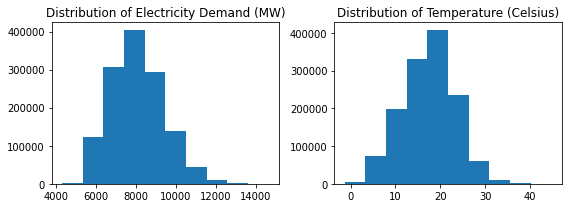

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot distributions of totaldemand and temperature
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
ax1.hist(df['TOTALDEMAND'])
ax1.title.set_text('Distribution of Electricity Demand (MW)')
ax2.hist(df['TEMPERATURE'])
ax2.title.set_text('Distribution of Temperature (Celsius)')
plt.tight_layout()
plt.show()
plt.clf()

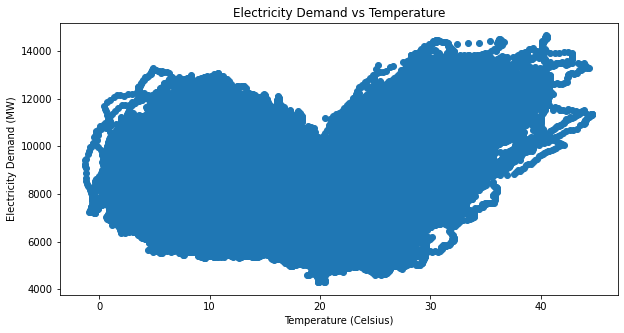

<function matplotlib.pyplot.clf()>

In [ ]:
# Plot totaldemand vs temperature
plt.figure(figsize=[10, 5])
plt.scatter(df['TEMPERATURE'], df['TOTALDEMAND'])
plt.ylabel('Electricity Demand (MW)')
plt.xlabel('Temperature (Celsius)')
plt.title('Electricity Demand vs Temperature')
plt.show()
plt.clf

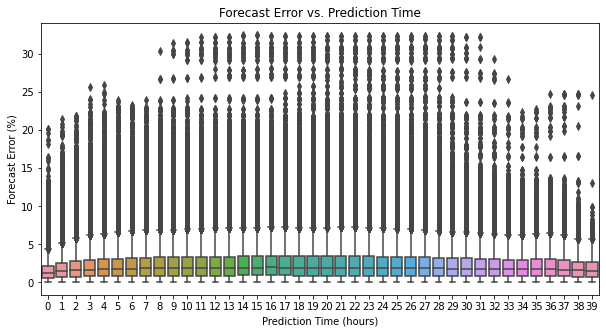

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot forecast error vs prediction time
plt.figure(figsize=[10, 5])
sns.boxplot(x='DURATION', y='ERROR', data=df_forecast).set(
    title='Forecast Error vs. Prediction Time',
    xlabel = 'Prediction Time (hours)',
    ylabel = 'Forecast Error (%)'
    )
plt.show()
plt.clf()

## Key findings from EDA
*   Right-skewed distribution for electricity demand data
*   Normal distribution for temperature data
*   Non-linear (U shape) relationship between electricity demand and temperature
*   Electricity demand is the lowest around 20 degree Celsius
*   Electricity demand increases at a higher rate under (i.e. more sensitive to) extreme hot weather
*   The longest prediction time for forecast demand is around 39 hours ahead of actual demand
*   Prediction tends to be more accurate within 2 hours before actual demand
*   Boxplot shows many outliers of forecast errors which extend to over 30%, indicating poor prediction performance of current model
*   Overall, predictions made by the current model is very short term and not reliable, hence not useful for energy planning

# Time Series Model

## Identify seasonality and trend

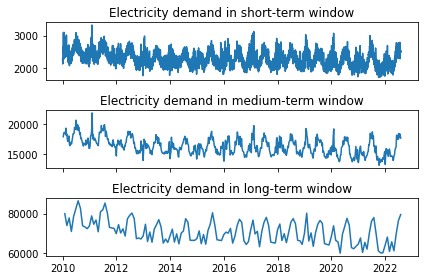

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot totaldemand vs time for different prediction time frames
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.plot(ts_short['TOTALDEMAND'])
ax1.title.set_text('Electricity demand in short-term window')
ax2.plot(ts_medium['TOTALDEMAND'])
ax2.title.set_text('Electricity demand in medium-term window')
ax3.plot(ts_long['TOTALDEMAND'])
ax3.title.set_text('Electricity demand in long-term window')
plt.tight_layout()
plt.show()
plt.clf()

### Findings on seasonality and trend:
*  Electricity demand shows seasonality patterns in all windows
*  Electricity demand has no significant trend (upward or downward) in all windows

## Augmented Dickey-Fuller (ADF) test for stationarity

In [ ]:
# Define ADF test function
def adf_test(series,title='',maxlag=None,autolag='AIC'):
    """
    series: data series
    title: add optional title
    maxlag: {None, int}, default value of 12*(nobs/100)^{1/4} 
      is used when None
    autolag: {“AIC” (default), “BIC”, “t-stat”, None}, 
      number of included lags is set to maxlag when None
    Hypothesis test:
    Ho: Data is non-stationary
    H1: Data is stationary
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),maxlag=maxlag,autolag=autolag) 
      # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string()) # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
# ADF test - short term 
adf_test(ts_short['TOTALDEMAND'],title='Demand (Short-term)')

Augmented Dickey-Fuller Test: Demand (Short-term)
ADF test statistic     -6.116561e+00
p-value                 9.064983e-08
# lags used             3.000000e+01
# observations          4.564000e+03
critical value (1%)    -3.431784e+00
critical value (5%)    -2.862173e+00
critical value (10%)   -2.567107e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# Apply differencing to short term demand
ts_short_demand_diff = ts_short['TOTALDEMAND'].diff().dropna()

In [ ]:
# Re-confirm stationarity by performing ADF test again
adf_test(ts_short_demand_diff,title='Demand (Short-term)')

Augmented Dickey-Fuller Test: Demand (Short-term)
ADF test statistic     -1.407158e+01
p-value                 2.933921e-26
# lags used             3.200000e+01
# observations          4.561000e+03
critical value (1%)    -3.431785e+00
critical value (5%)    -2.862174e+00
critical value (10%)   -2.567107e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# ADF test - medium term
adf_test(ts_medium['TOTALDEMAND'],title='Demand (Medium-term)')

Augmented Dickey-Fuller Test: Demand (Medium-term)
ADF test statistic       -4.078956
p-value                   0.001049
# lags used              15.000000
# observations          640.000000
critical value (1%)      -3.440609
critical value (5%)      -2.866067
critical value (10%)     -2.569181
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# Apply differencing to medium term demand
ts_medium_demand_diff = ts_medium['TOTALDEMAND'].diff().dropna()

In [ ]:
# Re-confirm stationarity by performing ADF test again
adf_test(ts_medium_demand_diff,title='Demand (Medium-term)')

Augmented Dickey-Fuller Test: Demand (Medium-term)
ADF test statistic     -1.036416e+01
p-value                 2.354013e-18
# lags used             1.900000e+01
# observations          6.350000e+02
critical value (1%)    -3.440690e+00
critical value (5%)    -2.866102e+00
critical value (10%)   -2.569200e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# ADF test - long term
adf_test(ts_long['TOTALDEMAND'],title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic       -2.007299
p-value                   0.283382
# lags used              12.000000
# observations          138.000000
critical value (1%)      -3.478648
critical value (5%)      -2.882722
critical value (10%)     -2.578065
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
# Apply differencing to long term demand
ts_long_demand_diff = ts_long.diff().dropna()

In [ ]:
# Re-confirm stationarity by performing ADF test again
adf_test(ts_long_demand_diff['TOTALDEMAND'],title='Demand (Long-term)')

Augmented Dickey-Fuller Test: Demand (Long-term)
ADF test statistic     -6.415848e+00
p-value                 1.842183e-08
# lags used             1.100000e+01
# observations          1.380000e+02
critical value (1%)    -3.478648e+00
critical value (5%)    -2.882722e+00
critical value (10%)   -2.578065e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Discussion on ADF test results:
*   ADF tests on demand data confirms stationarity for short term and medium term, but not for long term
*   First-order differencing has been applied to long term demand data, and subsequent ADF test confirms stationarity 
*   The assumption of stationarity for time series model is met

## Optimal parameters

In [ ]:
# Find short-term optimal parameters
sarima_short_optimal = auto_arima(ts_short['TOTALDEMAND'],exogenous=ts_short['TEMPERATURE'],seasonal=True,m=7,suppress_warnings=True)

# m=7 as weekly seasonality is assumed on daily data 

print('Optimal order (short term demand):', sarima_short_optimal.order)
print('Optimal seasonal_order (short term demand):', sarima_short_optimal.seasonal_order)

Optimal order (short term demand): (0, 1, 4)
Optimal seasonal_order (short term demand): (2, 0, 0, 7)


In [ ]:
# Find medium-term optimal parameters
sarima_medium_optimal = auto_arima(ts_medium['TOTALDEMAND'],exogenous=ts_medium['TEMPERATURE'],seasonal=True,m=52,suppress_warnings=True)
# m=52 as monthly seasonality is assumed on weekly data https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period

print('Optimal order (medium term demand):', sarima_medium_optimal.order)
print('Optimal seasonal_order (medium term demand):', sarima_medium_optimal.seasonal_order)

Optimal order (medium term demand): (1, 1, 1)
Optimal seasonal_order (medium term demand): (1, 0, 2, 52)


In [ ]:
# Find long-term optimal parameters
sarima_long_optimal = auto_arima(ts_long_demand_diff['TOTALDEMAND'],exogenous=ts_long_demand_diff['TEMPERATURE'],seasonal=True,m=12,suppress_warnings=True)
# m=12 as yearly seasonality is assumed on monthly data

print('Optimal order (long term demand):', sarima_long_optimal.order)
print('Optimal seasonal_order (long term demand):', sarima_long_optimal.seasonal_order)

Optimal order (long term demand): (1, 0, 1)
Optimal seasonal_order (long term demand): (1, 1, 1, 12)


### Summary of optimal paramters:
*   Short-term demand: SARIMA(0,0,4)x(2,0,0,7)
*   Medium-term demand: SARIMA(0,0,1)x(0,0,2,52) # Note: seasonal order not detected, need to re-examine seasonal pattern
*   Long-term demand: SARIMA(1,0,1)x(1,1,1,12)

## Fit the model

### Train and Test Split - Short Term

In [19]:
short_train_start_dt = date(2010,1,1)
short_train_end_dt = date(2019,12,31)
short_test_start_dt = date(2020,1,1)
short_test_end_dt = date(2022,7,31)
# difference between current and previous date
short_delta = timedelta(days=1)

# train dates
# store the dates between two dates in a list
short_ts_train_dates = []

while short_train_start_dt <= short_train_end_dt:
    # add current date to list by converting  it to iso format
    short_ts_train_dates.append(short_train_start_dt.isoformat())
    # increment start date by timedelta
    short_train_start_dt += short_delta

# test dates
# store the dates between two dates in a list
short_ts_test_dates = []

while short_test_start_dt <= short_test_end_dt:
    # add current date to list by converting  it to iso format
    short_ts_test_dates.append(short_test_start_dt.isoformat())
    # increment start date by timedelta
    short_test_start_dt += short_delta

### Train and Test Split - Medium Term

In [20]:
medium_train_start_dt = date(2010,1,10)
medium_train_end_dt = date(2019,12,31)
medium_test_start_dt = date(2020,1,5)
medium_test_end_dt = date(2022,7,31)
# difference between current and previous date
medium_delta = timedelta(weeks=1)

# train dates
# store the dates between two dates in a list
medium_ts_train_dates = []

while medium_train_start_dt <= medium_train_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_train_dates.append(medium_train_start_dt.isoformat())
    # increment start date by timedelta
    medium_train_start_dt += medium_delta

# test dates
# store the dates between two dates in a list
medium_ts_test_dates = []

while medium_test_start_dt <= medium_test_end_dt:
    # add current date to list by converting  it to iso format
    medium_ts_test_dates.append(medium_test_start_dt.isoformat())
    # increment start date by timedelta
    medium_test_start_dt += medium_delta

### Train and Test Split - Long Term

In [21]:
long_train_start_dt = date(2010,1,31)
long_train_end_dt = date(2019,12,31)
long_test_start_dt = date(2020,1,31)
long_test_end_dt = date(2022,7,31)

# train dates
# store the dates between two dates in a list
long_ts_train_dates = []

while long_train_start_dt <= long_train_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_train_dates.append(long_train_start_dt.isoformat())
    next_day_train = long_train_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_train_start_dt += timedelta(days=(monthrange(next_day_train.year,next_day_train.month)[1]))

# test dates
# store the dates between two dates in a list
long_ts_test_dates = []

while long_test_start_dt <= long_test_end_dt:
    # add current date to list by converting  it to iso format
    long_ts_test_dates.append(long_test_start_dt.isoformat())
    next_day_test = long_test_start_dt + timedelta(days = 1)
    # increment start date by timedelta
    long_test_start_dt += timedelta(days=(monthrange(next_day_test.year,next_day_test.month)[1]))

### Summary of Train and Test Data

In [22]:
# Short term prediction split:
ts_short_train = ts_short.loc[short_ts_train_dates]
ts_short_test = ts_short.loc[short_ts_test_dates]

# Medium term prediction split:
ts_medium_train = ts_medium.loc[medium_ts_train_dates]
ts_medium_test = ts_medium.loc[medium_ts_test_dates]

# # Long term prediction split:
ts_long_train = ts_long.loc[long_ts_train_dates]
ts_long_test = ts_long.loc[long_ts_test_dates]

## Fit Model on Training Data

### Short-term demand: SARIMA(0,0,4)x(2,0,0,7)



In [40]:
# ts_sarima_short_train = ts_short_train.drop(['TEMPERATURE'], axis=1)
short_order = sarima_short_optimal.order
short_seasonal_order = sarima_short_optimal.seasonal_order
short_model = SARIMAX(ts_short_train['TOTALDEMAND'], order = short_order, seasonal_order= short_seasonal_order)
short_model_fit = short_model.fit()

NameError: ignored

### Medium-term demand: SARIMA(0,0,1)x(0,0,2,52) 

In [ ]:
# ts_sarima_medium_train = ts_medium_train.drop(['TEMPERATURE'], axis=1)
medium_order = sarima_medium_optimal.order
medium_seasonal_order = sarima_medium_optimal.seasonal_order
medium_model = SARIMAX(ts_medium_train['TOTALDEMAND'], order = medium_order, seasonal_order= medium_seasonal_order)
medium_model_fit = medium_model.fit()

### Long-term demand: SARIMA(1,0,1)x(1,1,1,12)

In [ ]:
# ts_sarima_long_train = ts_long_train.drop(['TEMPERATURE'], axis=1)
long_order = sarima_long_optimal.order
long_seasonal_order = sarima_long_optimal.seasonal_order
long_model = SARIMAX(ts_long_train['TOTALDEMAND'], order = long_order, seasonal_order= long_seasonal_order)
long_model_fit = long_model.fit()

## Forecast

### Short-term

In [ ]:
short_forecast = short_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exogenous=ts_short_train['TEMPERATURE'])

#### Plot Results

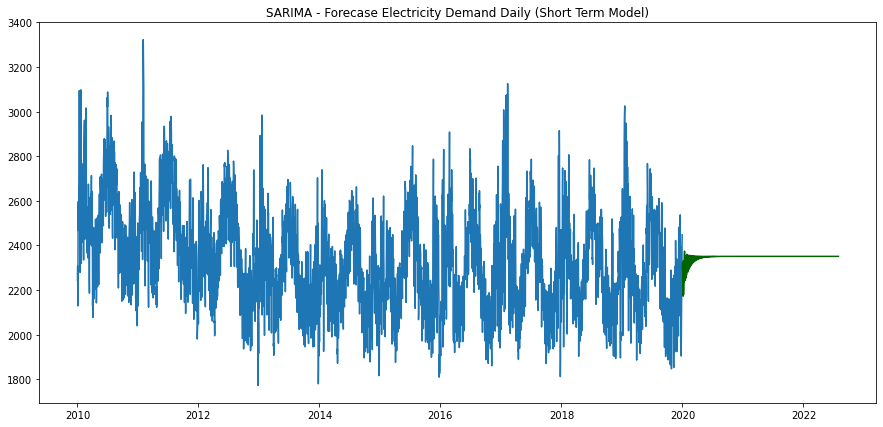

In [ ]:
fitted_series_short = pd.Series(short_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_short_train["TOTALDEMAND"], color='#1f76b4')
plt.plot(fitted_series_short, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                 lower_series, 
#                 upper_series, 
#                 color='k', alpha=.15)

plt.title("SARIMA - Forecase Electricity Demand Daily (Short Term Model)")
plt.show()

### Medium-term

In [ ]:
medium_forecast = medium_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exogenous=ts_medium_train['TEMPERATURE'])

#### Plot Results

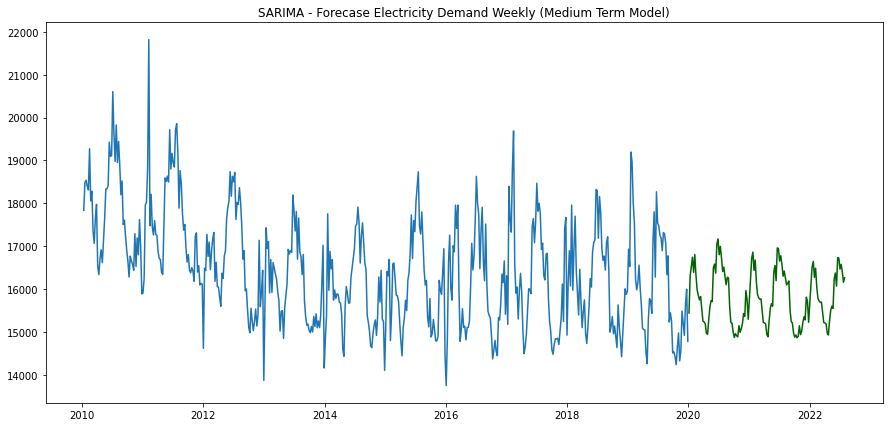

In [ ]:
fitted_series_medium = pd.Series(medium_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_medium_train["TOTALDEMAND"], color='#1f76b4')
plt.plot(fitted_series_medium, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                 lower_series, 
#                 upper_series, 
#                 color='k', alpha=.15)

plt.title("SARIMA - Forecase Electricity Demand Weekly (Medium Term Model)")
plt.show()

### Long-term

In [ ]:
long_forecast = long_model_fit.predict(start = date(2020,1,1) , end = date(2022,7,31), exogenous=ts_long_train['TEMPERATURE'])

#### Plot Results

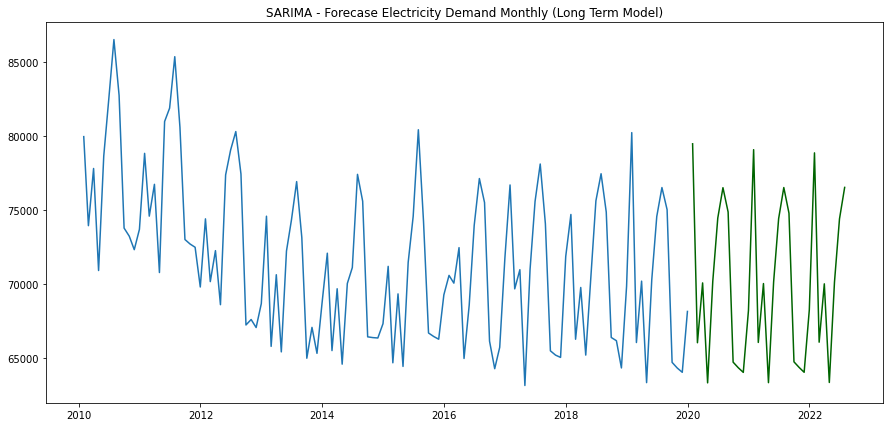

In [ ]:
fitted_series_long = pd.Series(long_forecast)
plt.figure(figsize=(15,7))
plt.plot(ts_long_train["TOTALDEMAND"], color='#1f76b4')
plt.plot(fitted_series_long, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                 lower_series, 
#                 upper_series, 
#                 color='k', alpha=.15)

plt.title("SARIMA - Forecase Electricity Demand Monthly (Long Term Model)")
plt.show()

## Performance Metrics

### Prepare Forecasted and Actual Demand Data

In [ ]:
#short term actual and predicted demand
actual_short = ts_short_test.drop(['TEMPERATURE'], axis=1)
predicted_short = short_forecast

#medium term actual and predicted demand
actual_medium = ts_medium_test.drop(['TEMPERATURE'], axis=1)
predicted_medium = medium_forecast

#long term actual and predicted demand
actual_long = ts_long_test.drop(['TEMPERATURE'], axis=1)
predicted_long = long_forecast

### Short Term Model Performance

In [ ]:
mae = mean_absolute_error(actual_short, predicted_short)
mse = mean_squared_error(actual_short, predicted_short)
mape = mean_absolute_percentage_error(actual_short, predicted_short)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 233.143114630824
Mean Squared Error: 74947.67392270581
Mean Absolute Percentage Error: 0.11045356113303255
Root Mean Squared Error: 273.7657281741194


### Medium Term Model Performance

In [ ]:
mae = mean_absolute_error(actual_medium, predicted_medium)
mse = mean_squared_error(actual_medium, predicted_medium)
mape = mean_absolute_percentage_error(actual_medium, predicted_medium)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 890.0553543068382
Mean Squared Error: 1111899.977310534
Mean Absolute Percentage Error: 0.05815913431996094
Root Mean Squared Error: 1054.466679089735


### Long Term Model Performance

In [ ]:
mae = mean_absolute_error(actual_long, predicted_long)
mse = mean_squared_error(actual_long, predicted_long)
mape = mean_absolute_percentage_error(actual_long, predicted_long)
rmse = math.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 3310.8071404121943
Mean Squared Error: 18133155.89565217
Mean Absolute Percentage Error: 0.05030825865978685
Root Mean Squared Error: 4258.304345118157


End of Code

# ELM Model

## Convert to R

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%reload_ext rpy2.ipython

In [ ]:
%%R
#for data processing 
library(tidyverse)
#for EDA
#install.packages("GGally")

library(GGally)
library(ggplot2)
#for ELM&regression
#install.packages("elmNNRcpp")
#install.packages("corrplot")
#install.packages("glmnet")
#install.packages("caret")
#install.packages("ELMR")
library(elmNNRcpp)
library(KernelKnn)
library(corrplot)
library(glmnet)
library(caret)
library(ELMR)

## Fit Model on Training Data - ELM

### Short-term demand

In [81]:
%%R -i ts_short_train -i ts_short_test
elm_short_train_x<-as.matrix(ts_short_train[,'TEMPERATURE'])
elm_short_train_y<-as.matrix(ts_short_train[,'TOTALDEMAND'])
elm_short_test_x<-as.matrix(ts_short_test[,'TEMPERATURE'])
elm_short_test_y<-as.matrix(ts_short_test[,'TOTALDEMAND'])
elm_short_model<-elm_train(elm_short_train_x,elm_short_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')

### Medium-term demand

In [82]:
%%R -i ts_medium_train -i ts_medium_test
elm_medium_train_x<-as.matrix(ts_medium_train[,'TEMPERATURE'])
elm_medium_train_y<-as.matrix(ts_medium_train[,'TOTALDEMAND'])
elm_medium_test_x<-as.matrix(ts_medium_test[,'TEMPERATURE'])
elm_medium_test_y<-as.matrix(ts_medium_test[,'TOTALDEMAND'])
elm_medium_model<-elm_train(elm_medium_train_x,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')

### Long-term demand

In [83]:
%%R -i ts_long_train -i ts_long_test
elm_long_train_x<-as.matrix(ts_long_train[,'TEMPERATURE'])
elm_long_train_y<-as.matrix(ts_long_train[,'TOTALDEMAND'])
elm_long_test_x<-as.matrix(ts_long_test[,'TEMPERATURE'])
elm_long_test_y<-as.matrix(ts_long_test[,'TOTALDEMAND'])
elm_long_model<-elm_train(elm_long_train_x,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')

## Forecast

### Short-term

In [84]:
%%R
elm_short_predict_y = elm_predict(elm_short_model,elm_short_test_x)
data.frame(rmse=sqrt(mean((elm_short_predict_y-elm_short_test_y)^2)),mape=mean(abs(elm_short_predict_y-elm_short_test_y)/elm_short_test_y))

      rmse       mape
1 212.5599 0.08363186


#### Plot Results

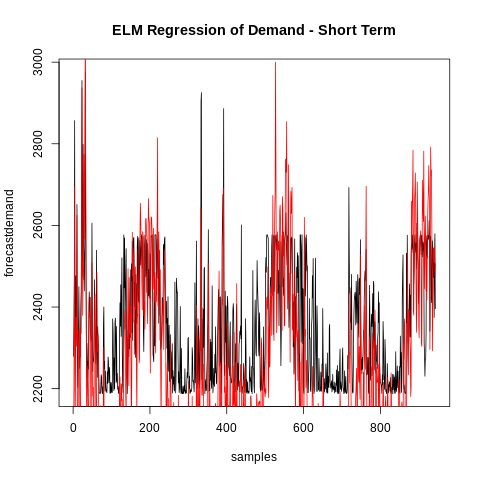

In [85]:
%%R
plot(elm_short_predict_y,type='l',xlab = 'samples',ylab = 'forecastdemand',main = 'ELM Regression of Demand - Short Term')
lines(elm_short_test_y,type = 'l',col="red")

### Medium-term

In [86]:
%%R
elm_medium_predict_y = elm_predict(elm_medium_model,elm_medium_test_x)
data.frame(rmse=sqrt(mean((elm_medium_predict_y-elm_medium_test_y)^2)),mape=mean(abs(elm_medium_predict_y-elm_medium_test_y)/elm_medium_test_y))

      rmse       mape
1 1160.009 0.06666132


#### Plot Results

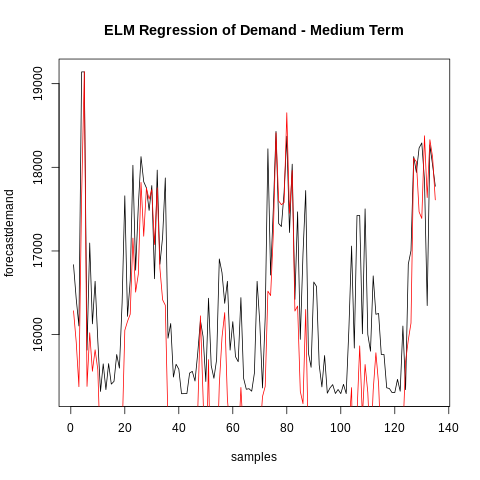

In [87]:
%%R
plot(elm_medium_predict_y,type='l',xlab = 'samples',ylab = 'forecastdemand',main = 'ELM Regression of Demand - Medium Term')
lines(elm_medium_test_y,type = 'l',col="red")

### Long-term

In [88]:
%%R
elm_long_predict_y = elm_predict(elm_long_model,elm_long_test_x)
data.frame(rmse=sqrt(mean((elm_long_predict_y-elm_long_test_y)^2)),mape=mean(abs(elm_long_predict_y-elm_long_test_y)/elm_long_test_y))

      rmse       mape
1 4857.827 0.06457552


#### Plot Results

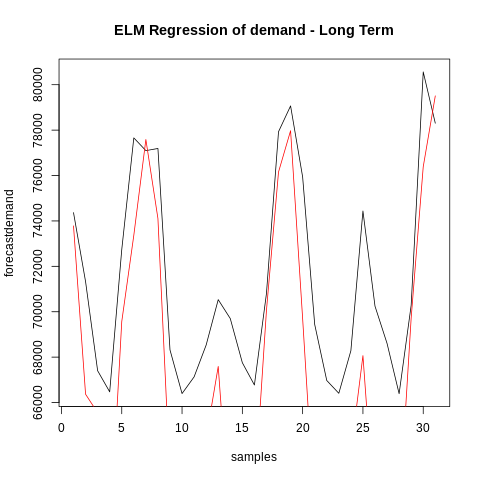

In [89]:
%%R
plot(elm_long_predict_y,type='l',xlab = 'samples',ylab = 'forecastdemand',main = 'ELM Regression of demand - Long Term')
lines(elm_long_test_y,type = 'l',col="red")

## Statistics Analysis - to be added

## Remodel with Additional Features

In [125]:
%%R

elm_short_train_x2<-cbind(elm_short_train_x,elm_short_train_x^2,elm_short_train_x^3)
elm_short_test_x2<-cbind(elm_short_test_x,elm_short_test_x^2,elm_short_test_x^3)

elm_short_model2<-elm_train(elm_short_train_x2,elm_short_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_short_predict_y2 = elm_predict(elm_short_model2,elm_short_test_x2)
data.frame(rmse=sqrt(mean((elm_short_predict_y2-elm_short_test_y)^2)),mape=mean(abs(elm_short_predict_y2-elm_short_test_y)/elm_short_test_y))

      rmse       mape
1 244.7715 0.09762442


In [126]:
%%R 
elm_medium_train_x2<-cbind(elm_medium_train_x,elm_medium_train_x^2,elm_medium_train_x^3)
elm_medium_test_x2<-cbind(elm_medium_test_x,elm_medium_test_x^2,elm_medium_test_x^3)

elm_medium_model2<-elm_train(elm_medium_train_x2,elm_medium_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_medium_predict_y2 = elm_predict(elm_medium_model2,elm_medium_test_x2)
data.frame(rmse=sqrt(mean((elm_medium_predict_y2-elm_medium_test_y)^2)),mape=mean(abs(elm_medium_predict_y2-elm_medium_test_y)/elm_medium_test_y))

      rmse       mape
1 1423.633 0.08070691


In [40]:
%%R 
elm_long_train_x2<-cbind(elm_long_train_x,elm_long_train_x^2,elm_long_train_x^3)
elm_long_test_x2<-cbind(elm_long_test_x,elm_long_test_x^2,elm_long_test_x^3)

elm_long_model2<-elm_train(elm_long_train_x2,elm_long_train_y,nhid=50,actfun='sig',init_weights='normal_gaussian')
elm_long_predict_y2 = elm_predict(elm_long_model2,elm_long_test_x2)
data.frame(rmse=sqrt(mean((elm_long_predict_y2-elm_long_test_y)^2)),mape=mean(abs(elm_long_predict_y2-elm_long_test_y)/elm_long_test_y))

      rmse       mape
1 5696.757 0.07527571


## Remodel with K-fold Cross Validation

In [95]:
%%R -i ts_short -i ts_medium -i ts_long

elm_model<-function(X_train, Y_train, X_test){
  elm <- elm_train(X_train, Y_train,nhid=50,actfun='sig',init_weights='normal_gaussian')
  Y_pred <- elm_predict(elm,X_test)
  return(Y_pred)
}

k_fold_cv <- function(data, k) {
  mse <- rep(0, k)  
  
  for(i in 1:k) {
    # split data
    folds <- cut(seq(1, nrow(data)), breaks = k, labels = FALSE)
    validation.index <- which(folds == i, arr.ind = TRUE)
    validation.data <- data[validation.index, ]
    train.data <- data[-validation.index, ]
    
    Y_pred <- elm_model(as.matrix(train.data[, 'TEMPERATURE']), as.matrix(train.data[, 'TOTALDEMAND']), 
                        as.matrix(validation.data[, 'TEMPERATURE']))
    
    mse[i] <- sum((Y_pred - validation.data[, 'TOTALDEMAND'])^2) / length(Y_pred)
  }
  
  cv_error <- mean(mse)  
  cv_rmse <- sqrt(cv_error)
  cv_mape <- mean(abs(Y_pred-validation.data[, 'TOTALDEMAND'])/validation.data[, 'TOTALDEMAND'])
  data.frame(rmse=cv_rmse,mape=cv_mape)
}


In [125]:
%%R
k_fold_cv(ts_short, 29)

      rmse       mape
1 187.6682 0.06008051


In [135]:
%%R
k_fold_cv(ts_medium, 35)

      rmse       mape
1 910.0821 0.03938129


In [142]:
%%R
k_fold_cv(ts_long, 30)

      rmse      mape
1 3730.751 0.0353603
